In [1]:
# autoreload to cast any changes to the module files into the notebook
%load_ext autoreload
%autoreload 2
import re, math, os, csv, timeit
import numpy as np
from datetime import date 

In [2]:
# configurations
# this script is applicatble only for ring-molecules
NUM_CARBON = 6
NUM_ATOMS = NUM_CARBON + 1*4 + 2*(NUM_CARBON-4)  # C*8 + H*(4 carbons in conjugated_sys) + (2H)*(carbons not in conj_sys)

# # represent C-H bonds
# # C6-H9
# # C7-H10
# # C8-H11
# # C1-H12
# # C5-H13 & C5-H14
# # C4-H15 & C4-H16
# # C3-H17 & C3-H20
# # C2-H18 & C2-H19
# carbon_list = [6,7,8,1,5,5,4,4,3,3,2,2]
# hydrogen_list = [9,10,11,12,13,14,15,16,17,20,18,19]


# bond lengths, angles and dihedrals for CHD, as you analysed for COD. 
# However, the ring-opening reaction occurs mainly through a different coordinate. 
# As the C5-C6 bond breaks in that case, also include the C5-C6 bond and the C4-C5-C6-C1 dihedral angle 

In [3]:
# Program flow
# --------------------------- Preprocess Data -------------------------
# loop file 
    # catch patterns
    # read 20 cooridnates into a block (list of coordinates)
    # append to list_of_blocks
    
# --------------------------- Perform Computation -------------------------
# loop through list of blocks 
# for index in len(list_of_blocks)
    # compute(block)
        
    # create new entries in list_of_dictionaries "Traj : 1, C1-C2: (double), C2-C3 (double), ... "
        
# --------------------------- Write to csv ---------------------------

In [4]:
# # --------------------------- Preprocess Data -------------------------

def get_lines_with_coordinates(fileName):
    ''' take in xyz file & grab lines with coordinates
        Input: fileName
        Output: a list of lines with coordinates
    '''
    searchfile = open(fileName, "r",encoding='utf-8')
    line_list = searchfile.readlines()
    line_list = [line for line in line_list if line != ' {} \n'.format(NUM_ATOMS)]    # strip all lines with " NUM_ATOMS \n"
    return line_list


def split_into_trajectory_blocks(line_list):
    ''' convert file line_list into trajectory_blocks
        Input: line_list
        Output: a list, trajectory_blocks
    '''
    trajectory_blocks = []
    for index, line in enumerate(line_list):
        if re.search(r'TRAJ\d+', line):
            # create new block for each trajectory
            trajectory_coordinates = get_trajectory_data(index,line_list)

            # append to list
            trajectory_blocks.append(trajectory_coordinates)            
    return trajectory_blocks


def get_trajectory_data(index, line_list):
    ''' read a trajetory --> if(match regex | EOF), return 
        Input: index, list_of_lines_in_file
        Output: a list coordinates for that block, first item= TRAJ#, remaining items np_arrays 
                each coordinate is in format [float(x), float(y), float(z)]
    '''
    trajectory_coordinates = [line_list[index][:-1]] # grab trajectory #
    for line in line_list[index+1:]:
        if (re.search(r'TRAJ\d+', line)):
            break
        else:
            atom,x,y,z = line.split()
            trajectory_coordinates.append(np.asarray([float(x), float(y), float(z)], dtype=np.float64))            
    return trajectory_coordinates 


def preprocess_data(fileName):    
    ''' Input: filename
        Output: a list of trajectory_blocks_in_file, 
        each block representing 1 trajectory
    '''
    line_list = get_lines_with_coordinates(fileName)
    traj_blocks_in_file = split_into_trajectory_blocks(line_list)
    return traj_blocks_in_file   

In [5]:
def get_angle_in_degree(unit_vectors):
    dih_angle = math.acos(unit_vectors[0].dot(unit_vectors[1]))*180/math.pi
    
    if dih_angle <= 180: #this is a property of the det. If the det > 0 then B is clockwise of A
        return dih_angle
    else: # if the det < 0 then B is anti-clockwise of A
        return -(360-dih_angle)

def compute_C_C_C_angle(*coords):
    ''' compute C-C-C angles
        Input: 2 lines of coordinates
        Output: angle (in degrees) 
    '''
    vectors = []
    # if appending in a large number of loops. 
    # faster to append to list first 
    # and convert to array than appending NumPy arrays.
    
    for point in range(len(coords)-1):
        vectors.append(np.subtract(coords[point+1],coords[point]))
    vectors[0] *= -1 # "Flip" the 1st vector
    unit_vectors = [ v/np.linalg.norm(v) for v in vectors]
    
    return get_angle_in_degree(unit_vectors)


def compute_dihedral(*coords):
    ''' build plane vectors, 
        compute normal-vectors of intersecting planes, 
        take arccos from dot product

        Input: a list of coordinates
        Output: dihedral_angle (in degrees)
    '''
    vectors = []
    for point in range(len(coords)-1):
        vectors.append(np.subtract(coords[point+1],coords[point]))

    vectors[0] *= -1 # "Flip" the 1st vector         
    n_vectors = [np.cross(v,vectors[1]) for v in [vectors[0], vectors[2]]]
    unit_vectors = [ v/np.linalg.norm(v) for v in n_vectors]
    
    return get_angle_in_degree(unit_vectors)

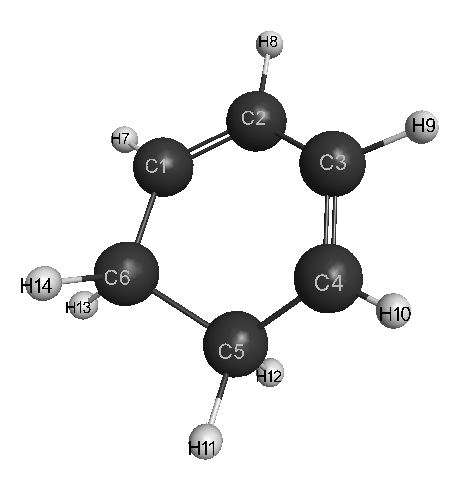

In [6]:
from IPython.display import display
from PIL import Image
iamge_file_path = os.path.join(".", "visuals", "molecules","CHD.PNG")
display(Image.open(iamge_file_path))

In [7]:
# --------------------------- Perform Computation -------------------------


# **************REFRACTOR this****************
def compute(block):
    ''' compute geometric params for each traj (bondlength, C_C_C angles, dihedrals H9-C6-C7-H10 and H11-C8-C1-H12.

        Input: a list of np_array, representing data for 1 traj
        Output:a dictionary, , representing data for 1 traj
        format : "TRAJ : 1, C1-C2: (double), C2-C3 (double), ... "
    '''    
    dictionary_for_trajectory = {}
    dictionary_for_trajectory['TRAJ'] = re.findall('\d+', block[0])[0]   # findall the numbers in the string block[0], return a list --> index [0] to get string value
    
    # ----------------Bondlength C - C ----------------
    for carbon in list(range(1, NUM_CARBON+1)): 
        if carbon == NUM_CARBON:
            bond_title="C{}-C{}".format(carbon,1)
            dictionary_for_trajectory[bond_title] = np.linalg.norm(block[carbon] - block[1])
        elif carbon != NUM_CARBON:     
            bond_title="C{}-C{}".format(carbon,carbon+1)
            dictionary_for_trajectory[bond_title] = np.linalg.norm(block[carbon] - block[carbon + 1]) 
#     # ----------------Bondlength C - H ----------------
#     for carbon,hydro in zip(carbon_list,hydrogen_list):
#         bond_title="C{}-H{}".format(carbon,hydro)
#         dictionary_for_trajectory[bond_title] = np.linalg.norm(block[carbon] - block[hydro])    
    
    # ---------------- C-C-C angles ------------------
    for carbon in list(range(1, NUM_CARBON+1)): 
        if carbon == 1: 
            angle_title="C{}-C{}-C{}".format(NUM_CARBON,carbon,carbon+1)
            dictionary_for_trajectory[angle_title] = compute_C_C_C_angle(block[NUM_CARBON],block[carbon],block[carbon+1])
        elif carbon == NUM_CARBON:   
            angle_title="C{}-C{}-C{}".format(carbon-1,carbon,1)
            dictionary_for_trajectory[angle_title] = compute_C_C_C_angle(block[carbon-1],block[carbon],block[1])
        else:
            angle_title="C{}-C{}-C{}".format(carbon-1,carbon,carbon+1)
            dictionary_for_trajectory[angle_title] = compute_C_C_C_angle(block[carbon-1],block[carbon],block[carbon+1])
    
    # ---------------- Dihedral angles ---------------
    dih_angle_title="dih H{}-C{}-C{}-H{}".format(7,1,2,8)
    dih_angle_title_2="dih H{}-C{}-C{}-H{}".format(9,3,4,10)
    dih_angle_title_3="dih C{}-C{}-C{}-C{}".format(4,5,6,1)
    dictionary_for_trajectory[dih_angle_title] = compute_dihedral(block[7],block[1],block[2],block[8])
    dictionary_for_trajectory[dih_angle_title_2] = compute_dihedral(block[9],block[3],block[4],block[10])
    dictionary_for_trajectory[dih_angle_title_3] = compute_dihedral(block[4],block[5],block[6],block[1])
    
    return dictionary_for_trajectory

In [10]:
# REFRACTOR this, add perform_computation function & write_to_CSV function

def compute_geometric_params(inputFile):
    ''' extract from xyz, compute, write to csv
        Input: inputFile
        Output: csv
    '''
    # --------------------------- Preprocess Data -------------------------
    list_of_blocks_in_file = preprocess_data(inputFile)
    # --------------------------- Perform Computation -------------------------
    list_of_traj_dictionaries = []
    for block in list_of_blocks_in_file:

        # compute(block)
        dictionary_for_trajectory = compute(block)

        # create new entries in list_of_dictionaries "Traj : 1, C1-C2: (double), C2-C3 (double), ... "
        list_of_traj_dictionaries.append(dictionary_for_trajectory)
    # --------------------------- Write to csv ---------------------------
    date_computed = str(date.today())
    file_path = os.path.join(".", "output", "CHD",date_computed + "_IC_CHD_initial" + ".csv")
    os.makedirs(os.path.dirname(file_path), exist_ok=True) # create 'output' folder if not existed yet

    with open(file_path, 'w', newline='', encoding='utf-8') as csvFile:
        field_names = list(list_of_traj_dictionaries[0].keys())
        writer = csv.DictWriter(csvFile, fieldnames=field_names, dialect='excel')

        writer.writeheader()
        for trajectory in list_of_traj_dictionaries:
            writer.writerow(trajectory)        

In [11]:
# %%timeit
def main():
    compute_geometric_params(os.path.join('.','input','CHD','CHD-initial.xyz'))

if __name__ == "__main__":
    main()  